### Time series tutorial using RNN, LSTM, GRU
https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/

In [1]:
from torch import nn
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
DATASET_PATH = './dataset/airline-passengers.txt'
assert os.path.exists(DATASET_PATH), 'Path to dataset does not exist'

In [3]:
df = pd.read_csv(DATASET_PATH, sep = ',')
print(df.shape)
df.head()

(144, 2)


,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [4]:
df.describe()

,Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


<Axes: ylabel='Passengers'>

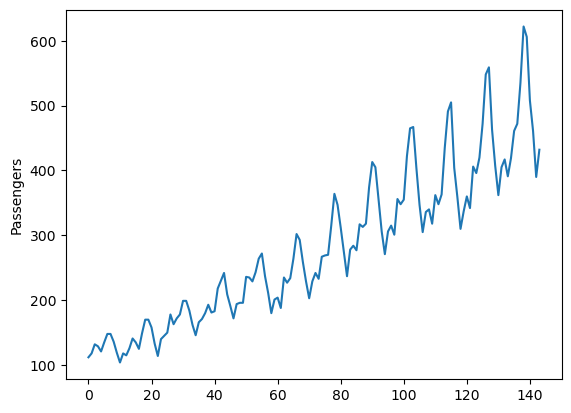

In [5]:
sns.lineplot(df, y = 'Passengers', x = df.index)

### Prep train and test data

In [6]:
train_df = df.drop("Month", axis = 1)
train_df = (train_df - train_df.min()) / (train_df.max() - train_df.min())
train_df.describe()


,Passengers
count,144.000000
mean,0.340345
std,0.231595
min,0.000000
25%,0.146718
50%,0.311776
75%,0.495174
max,1.000000


In [7]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

In [ ]:
def prep_series_dataset(df, timestep = 10):
    X = []
    y = []
    N = len(df)
    features = np.array(df)

    for i in range(len(df) - timestep):
        X.append(features[i: i + timestep])
        y.append(features[i + timestep])
    return np.array(X), np.array(y)

#quick test
print('array = ', np.array(df[:10]['Close']))
X,y = prep_series_dataset(df[:10]['Close'], timestep = 5)
print('X shape = ', X.shape)
print('X = ', X)
print('y shape =', y.shape)
print('y = ', y)

In [ ]:
timestep = 5

X, y = create_dataset(np.array(train_df['Passengers']), timestep)
X = torch.tensor(X).to(torch.float64).unsqueeze(-1)
y = torch.tensor(y).to(torch.float64)
print(X.shape, ' dtype = ', X.dtype)
print(y.shape, ' dtype = ', y.dtype) 

torch.Size([139, 5, 1])  dtype =  torch.float64
torch.Size([139, 5])  dtype =  torch.float64


/var/folders/_s/m9kt_szd4qq9brspl9hd44mc0000gn/T/ipykernel_26550/2602809963.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X).to(torch.float64).unsqueeze(-1)
/var/folders/_s/m9kt_szd4qq9brspl9hd44mc0000gn/T/ipykernel_26550/2602809963.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y).to(torch.float64)


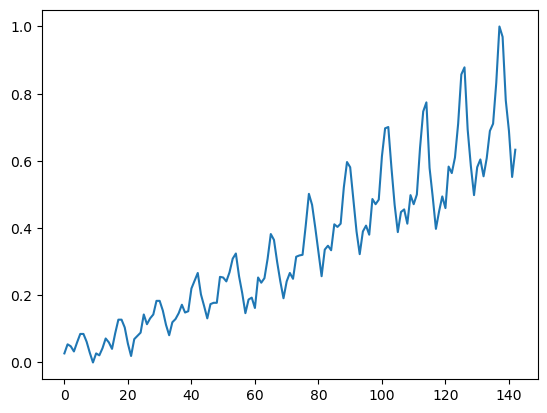

In [ ]:
sns.lineplot(y = y.squeeze(-1), x = list(range(len(y))))
plt.show()

In [9]:
train_size = 0.8
x_train, x_val_test, y_train, y_val_test = train_test_split(X, y, train_size = train_size, shuffle = False)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size = 0.5, shuffle = False)

print("X train shape = ", x_train.shape)
print("y train shape = ", y_train.shape)
print("X val shape = ", x_val.shape)
print("y val shape = ", y_val.shape)
print("X test shape = ", x_test.shape)
print("y test shape = ", y_test.shape)

NameError: name 'X' is not defined

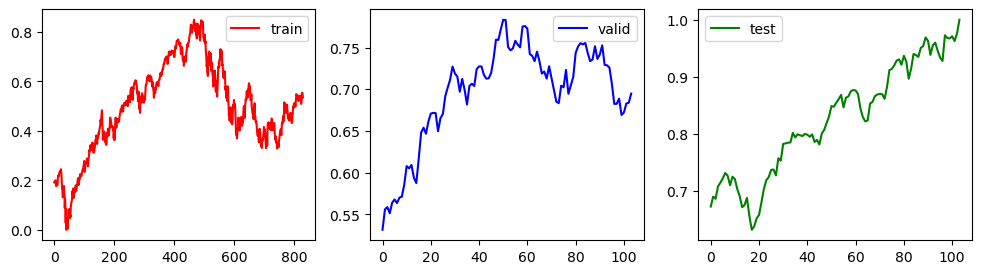

In [96]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (12,3))
sns.lineplot(y = y_train, x = list(range(len(y_train))), label = 'train', ax = ax1, color = 'red')
sns.lineplot(y = y_val, x = list(range(len(y_val))), label = 'valid', ax = ax2, color = 'blue')
sns.lineplot(y = y_test, x = list(range(len(y_test))), label = 'test', ax = ax3, color = 'green')
plt.show()

/Users/jamesnguyen/anaconda3/envs/torch/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
loss = 0.004202995049286655: 100%|██████████| 500/500 [00:01<00:00, 438.88it/s] 


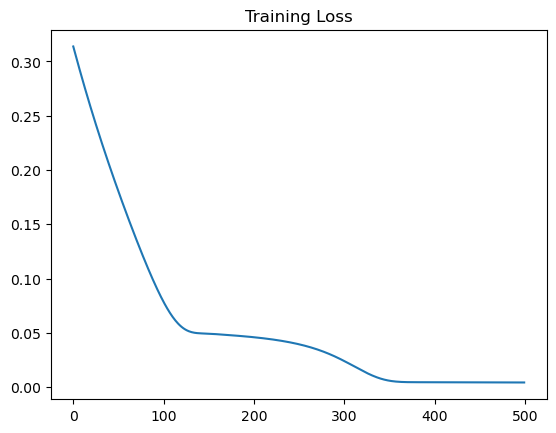

In [21]:
class LSTMModel(nn.Module):
  def __init__(self, input_dim, hidden_dim = 50, num_layers= 1):
    super(LSTMModel, self).__init__()
    self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dtype = torch.float64)
    self.fc = nn.LazyLinear(1, dtype = torch.float64)

  def forward(self, x):
    x, _ = self.lstm(x)
    # Get the output of the last time step
    x = x[:, -1, :]
    x = self.fc(x)
    return x

# Example usage
batch, numstep, input_size = X.shape
model = LSTMModel(input_size, 10, 3)  # Input dim, hidden dim, output dim
# X = torch.rand((10, 1, 1)).type(torch.float64)

# y_pred = model(X)
# print(y_pred.shape)
# y_pred = y_pred.squeeze(-1)

# # # Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

# y = torch.rand(10).to(torch.float64)

# loss = criterion(y, y_pred)
# loss.backward()
# optimizer.step()



# # Train the model (replace with your actual training loop)
loop = tqdm(range(500))
history = []
for epoch in loop: 
  # Get predictions
  y_pred = model(X)
  loss = criterion(y_pred, y)
  
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  loop.set_description(f"loss = {loss.item()}")
  history.append(loss.item())

sns.lineplot(y = history, x = list(range(len(history))))
plt.title("Training Loss")
plt.show()

(143,)


<Axes: >

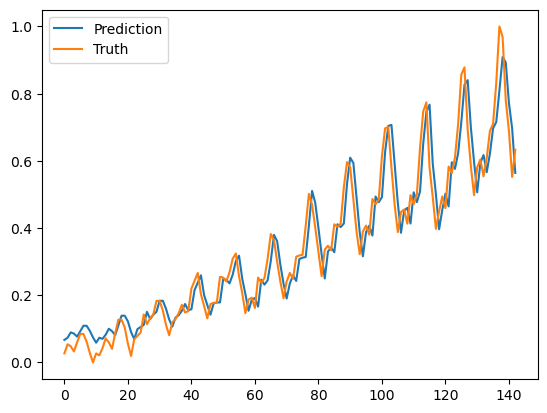

In [23]:
y_pred = model(X)
y_pred = y_pred.squeeze(-1).detach().numpy()
print(y_pred.shape)

sns.lineplot(x = list(range(len(y_pred))), y = y_pred, label = 'Prediction')
sns.lineplot(x = list(range(len(y))), y = y.squeeze(-1), label = 'Truth')
